In [224]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
import torch

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import boto3
import io
from tqdm import tqdm
from data_processing import sort_images, binary_search


## 1. Extract data

In [15]:
def get_category_and_subcategory(filenames,key):
    
    filename = key.split('/')[-1]

    # we are going to do a binary search to find the filename in the excel file

    index = binary_search(filenames, filename)
    
    i = index

    row = excel_data[index:index+1]
    category = row['WASTE_TYPE'][i]
    sub_category = row['WASTE_SUB_TYPE'][i]

    return category,sub_category

In [26]:
from data_processing import sort_images, binary_search

s3 = boto3.client('s3')
bucket_name = 'trashback-data'
excel_file_key = 'waste_pics.xlsx'
image_folder_key = 'trashback-images/'
target_folder_name = 'sorted_images_test/'

sort_images(bucket_name,image_folder_key,target_folder_name,excel_file_key)

Sorting 6411 images...


Progress: 100%|██████████| 6411/6411 [59:46<00:00,  1.79images/s]  


Images sorted successfully.


In [167]:
def create_folder_names_from_excel(excel_data):

    '''

    input : excel_data with 'WASTE_TYPE' and 'WASTE_SUB_TYPE' in the keys

    output : folder_names 

    '''

    folder_names = []
    excel_data.dropna()

    for i in range(45080):
        category = excel_data['WASTE_TYPE'][i]
        #sub_cat = excel_data['WASTE_SUB_TYPE'][i]

        folder_name = str(category) + '/' + str(sub_cat) + '/'
        if folder_name not in folder_names:
            folder_names.append(folder_name)

    return folder_names


In [168]:
def create_folders_if_needed(folder_name,folder_names):
    '''

    input : a list of folder names, with category & subcategory : 'Plastique/Autre déchet plastique/

    output : nothing but created the folders if not in the s3 bucket (within sorted images)

    ''' 

    for string in folder_names:
        category,sub_category = string.split('/')[0],string.split('/')[1]

        try:
            s3.head_object(Bucket=bucket_name, Key=f'{folder_name}/{category}/')
        except s3.exceptions.ClientError as e:
            if e.response['Error']['Code'] == '404':
                s3.put_object(Bucket=bucket_name, Key=f'{folder_name}/{category}/', Body='')

        # Create "sub-category" folder if it does not exist

        try:
            s3.head_object(Bucket=bucket_name, Key=f'{folder_name}/{category}/{sub_category}')
        except s3.exceptions.ClientError as e:
            if e.response['Error']['Code'] == '404':
                s3.put_object(Bucket=bucket_name, Key=f'{folder_name}/{category}/{sub_category}', Body='')

    print("Folders created successfully.")
#create_folders_if_needed(folder_names)

### 2. Creating the model

In [18]:
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

2024-02-20 13:06:24.509616: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-20 13:06:24.563271: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [169]:
bucket_name = 'trashback-data'
test_folder_key = 'sorted_images_test/'
train_folder_key = 'sorted_images/'
excel_file_key = 'waste_pics.xlsx'


s3 = boto3.client('s3')

excel_obj = s3.get_object(Bucket=bucket_name, Key=excel_file_key)
excel_data = pd.read_excel(io.BytesIO(excel_obj['Body'].read()))


categories = create_folder_names_from_excel(excel_data)  #methode longue pour extraire les categories
num_classes = len(categories)


Model creation

In [170]:
# we are going to create a dictionary with the keys of images as well as their category
from data_processing import list_keys

def create_dict_of_images(bucket_name,folder_key,excel_data):

    keys = list_keys(bucket_name,folder_key)

    dict_of_images = {}
    keys = []
    

    for key in keys:
        category,sub_category = get_category_and_subcategory(excel_data,key)
        dict_of_images[key] = category + '/' + sub_category

    return dict_of_images


In [171]:
from data_processing import list_keys

keys = list_keys(bucket_name,test_folder_key)

In [172]:
dict_of_images = {}
dict_filenames = {}

for key in keys:
    filename = key.split('/')[-1]
    category,sub_category = key.split('/')[-3],key.split('/')[-2]
    dict_of_images[key] = category + '/' + sub_category
    dict_filenames[filename] = category #+ '/' + sub_category



In [173]:
# I want to convert this dictionnaire into a dataframe

df = pd.DataFrame(list(dict_of_images.items()),columns = ['path','category'])
df2 = pd.DataFrame(list(dict_filenames.items()),columns = ['filename','category'])

#we shuffle the dataframe

df = df.sample(frac=1).reset_index(drop=True)
df2 = df2.sample(frac=1).reset_index(drop=True)

In [174]:
def split_data(data,ratio):
    last=int(len(data)*ratio)
    return data[:last], data[last:]

In [175]:
print(len(os.listdir('/home/sagemaker-user/waste-scan/data')))

3245


In [176]:
base_path = '/home/sagemaker-user/waste-scan/data/'

df2['filename'] = base_path + df2['filename']

In [182]:
train,test=split_data(df2,.8)


In [62]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [178]:
categories = excel_data['WASTE_TYPE'].unique()


In [183]:
train.head()

,filename,category
0,/home/sagemaker-user/waste-scan/data/1703266122641-image1703266136747.jpg,Métaux
1,/home/sagemaker-user/waste-scan/data/1698589650312-image1698589369279.jpg,Plastique
2,/home/sagemaker-user/waste-scan/data/1702302822419-image1702300405766.jpg,Métaux
3,/home/sagemaker-user/waste-scan/data/1698662209592-image1698662193110.jpg,Plastique
4,/home/sagemaker-user/waste-scan/data/1698836899412-image1698836926715.jpg,Métaux


In [187]:
train["category"].value_counts()

category
Plastique              2096
Métaux                 1359
Papier ou Carton        836
Verre                   506
Mégots                  168
Textile                 116
Matières Organiques      50
Name: count, dtype: int64

In [188]:
test["category"].value_counts()

category
Plastique              544
Métaux                 319
Papier ou Carton       209
Verre                  117
Mégots                  50
Textile                 33
Matières Organiques      8
Name: count, dtype: int64

In [189]:
train,valid=split_data(train,.9)


In [190]:
train


,filename,category
0,/home/sagemaker-user/waste-scan/data/1703266122641-image1703266136747.jpg,Métaux
1,/home/sagemaker-user/waste-scan/data/1698589650312-image1698589369279.jpg,Plastique
2,/home/sagemaker-user/waste-scan/data/1702302822419-image1702300405766.jpg,Métaux
3,/home/sagemaker-user/waste-scan/data/1698662209592-image1698662193110.jpg,Plastique
4,/home/sagemaker-user/waste-scan/data/1698836899412-image1698836926715.jpg,Métaux
...,...,...
4644,/home/sagemaker-user/waste-scan/data/1705163906294-image1705163949855.jpg,Papier ou Carton
4645,/home/sagemaker-user/waste-scan/data/1702628895268-image1702628915757.jpg,Papier ou Carton
4646,/home/sagemaker-user/waste-scan/data/1698940126039-image1698940124908.jpg,Métaux
4647,/home/sagemaker-user/waste-scan/data/1705162659408-image1705162690523.jpg,Plastique


In [ ]:
#we are going to convert paths into s3 urls

def convert_to_s3_url(bucket_name,df):
    df['path'] = 's3://' + bucket_name + '/' + df['path']
    return df

train = convert_to_s3_url(bucket_name,train)
valid = convert_to_s3_url(bucket_name,valid)
test = convert_to_s3_url(bucket_name,test)

In [60]:
pwd

'/home/sagemaker-user/waste-scan/data'

In [192]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 16
size=224
epoch=50
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='filename',
    y_col='category',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input"
    )
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col='filename',
    y_col='category',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input"
    )

Found 2275 validated image filenames.
Found 258 validated image filenames.


/opt/conda/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2342 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 256 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [193]:
train.head()

,filename,category
0,/home/sagemaker-user/waste-scan/data/1703266122641-image1703266136747.jpg,Métaux
1,/home/sagemaker-user/waste-scan/data/1698589650312-image1698589369279.jpg,Plastique
2,/home/sagemaker-user/waste-scan/data/1702302822419-image1702300405766.jpg,Métaux
3,/home/sagemaker-user/waste-scan/data/1698662209592-image1698662193110.jpg,Plastique
4,/home/sagemaker-user/waste-scan/data/1698836899412-image1698836926715.jpg,Métaux


In [198]:
valid.head()

,filename,category
4649,/home/sagemaker-user/waste-scan/data/1701778403358-image1701778368423.jpg,Papier ou Carton
4650,/home/sagemaker-user/waste-scan/data/1705737266023-image1705737309948.jpg,Papier ou Carton
4651,/home/sagemaker-user/waste-scan/data/1701773377212-image1701773340787.jpg,Plastique
4652,/home/sagemaker-user/waste-scan/data/1698580808685-user.jpg,Verre
4653,/home/sagemaker-user/waste-scan/data/1703334658662-image1703334672110.jpg,Papier ou Carton


In [6]:
#import cv2
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, GlobalAveragePooling2D, SeparableConv2D,\
ZeroPadding2D, Convolution2D, ZeroPadding2D, Conv2DTranspose,ReLU, UpSampling2D, Concatenate, Conv2DTranspose

In [89]:
def se_block_enc(inputs,alpha):
    input_channels = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(units=alpha, activation="relu")(x)    
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)    
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x

In [195]:

# ENCODER
input_img = Input(shape=(size,size, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x=se_block_enc(x,20)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x=se_block_enc(x,30)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x=se_block_enc(x,50)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Bottolneck
latentSize = (28,28,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))


In [196]:
autoencoder.summary()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 224, 224, 48)         1344      ['input_6[0][0]']             
                                                                                                  
 global_average_pooling2d_1  (None, 48)                   0         ['conv2d_20[0][0]']           
 0 (GlobalAveragePooling2D)                                                                       
                                                                                                  
 dense_25 (Dense)            (None, 20)                   980       ['global_average_poolin

In [94]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [197]:
autoencoder.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='binary_crossentropy')
history = autoencoder.fit_generator(train_generator,
                                 validation_data= valid_generator,
        epochs = epoch, verbose=2)

/tmp/ipykernel_212/724798508.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(train_generator,


Epoch 1/50
143/143 - 57s - loss: 0.6307 - val_loss: 0.6261 - 57s/epoch - 398ms/step
Epoch 2/50
143/143 - 46s - loss: 0.6108 - val_loss: 0.6184 - 46s/epoch - 321ms/step
Epoch 3/50
143/143 - 46s - loss: 0.6046 - val_loss: 0.6159 - 46s/epoch - 323ms/step
Epoch 4/50
143/143 - 46s - loss: 0.6031 - val_loss: 0.6141 - 46s/epoch - 323ms/step
Epoch 5/50
143/143 - 46s - loss: 0.6014 - val_loss: 0.6129 - 46s/epoch - 322ms/step
Epoch 6/50
143/143 - 46s - loss: 0.6001 - val_loss: 0.6145 - 46s/epoch - 322ms/step
Epoch 7/50
143/143 - 46s - loss: 0.5987 - val_loss: 0.6114 - 46s/epoch - 323ms/step
Epoch 8/50
143/143 - 46s - loss: 0.5980 - val_loss: 0.6091 - 46s/epoch - 323ms/step
Epoch 9/50
143/143 - 46s - loss: 0.5970 - val_loss: 0.6086 - 46s/epoch - 323ms/step
Epoch 10/50
143/143 - 46s - loss: 0.5959 - val_loss: 0.6086 - 46s/epoch - 323ms/step
Epoch 11/50
143/143 - 46s - loss: 0.5954 - val_loss: 0.6073 - 46s/epoch - 322ms/step
Epoch 12/50
143/143 - 46s - loss: 0.5946 - val_loss: 0.6066 - 46s/epoch - 

/tmp/ipykernel_212/836443083.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.
  ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')


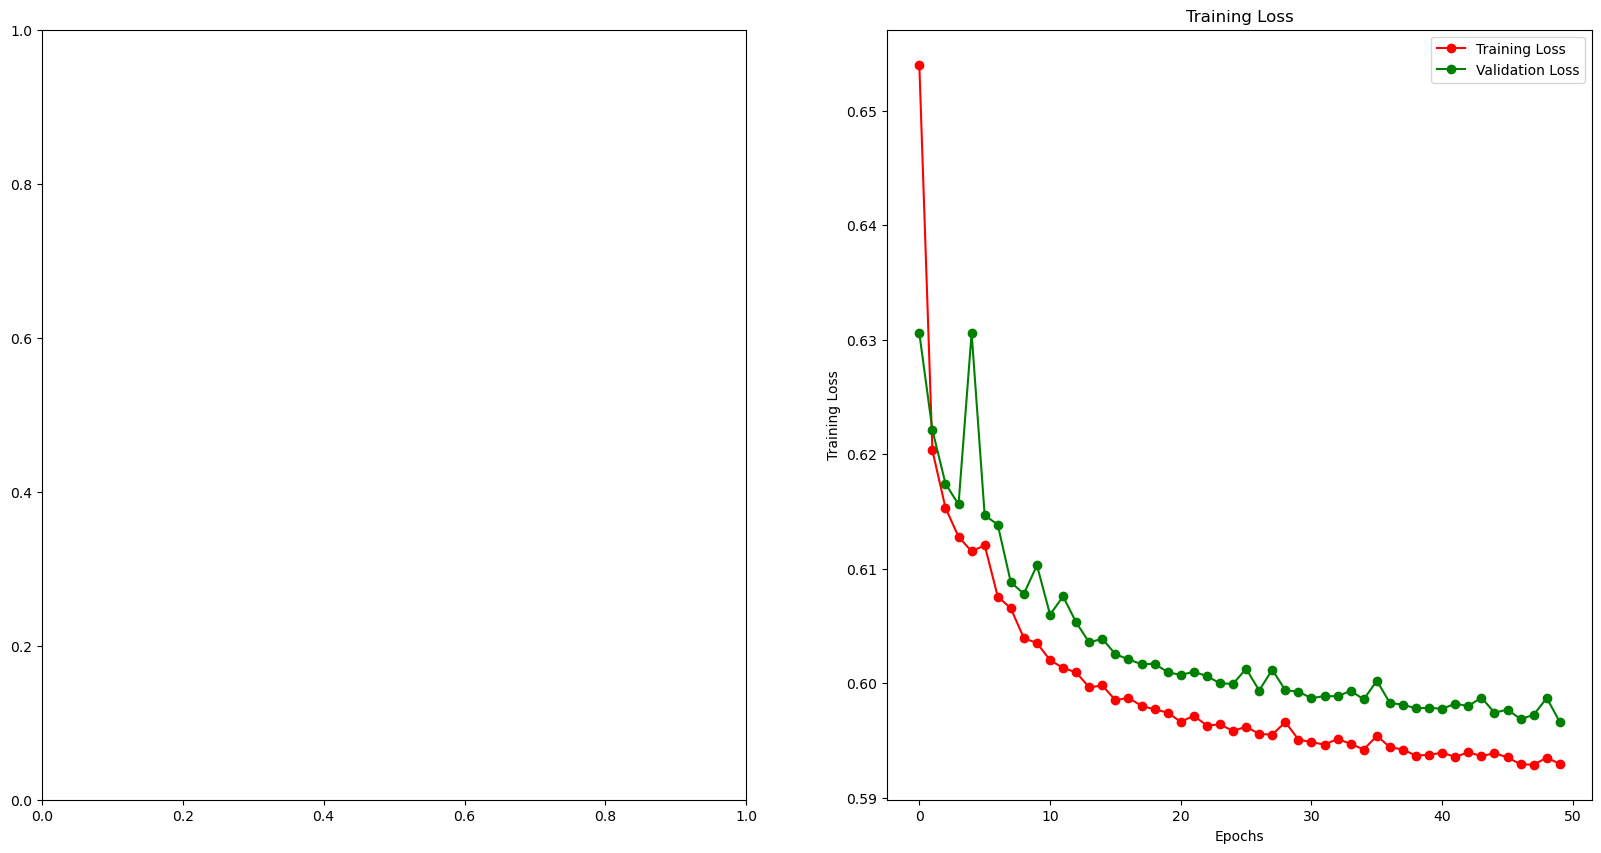

In [97]:
epochs = list(range(len(history.history['loss'])))
fig , ax = plt.subplots(1,2)

train_loss = history.history['loss']

val_loss = history.history['val_loss']

fig.set_size_inches(20,10)



ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

In [199]:
autoencoder.save("auto_encoder2.h5")
encoder.save('encoder2.h5')
decoder.save('decoder2.h5')

/opt/conda/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 376ms/step


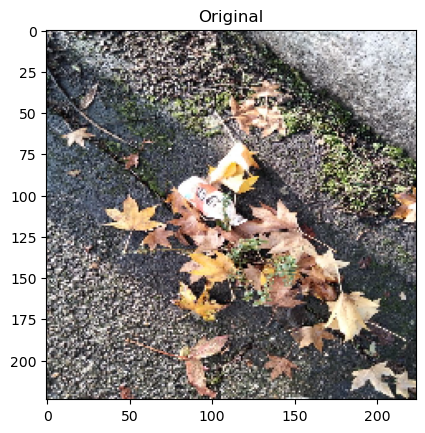

In [117]:
orig = cv2.imread(test.iloc[1]['filename']) 
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
orig=orig* 1.0 / 255.0
orig = cv2.resize(orig, (size, size),
               interpolation = cv2.INTER_NEAREST)
img = tf.expand_dims(orig, axis=0)

encoder_output=encoder.predict(img)
plt.title('Original')
plt.imshow(orig)

In [118]:
encoder_output.shape


(1, 28, 28, 32)

Text(0.5, 1.0, 'a samplt output of encoded image')

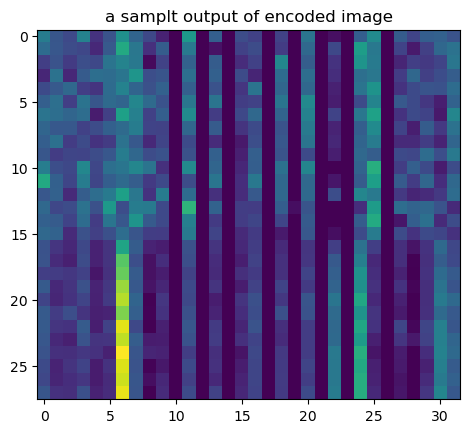

In [119]:
plt.imshow(encoder_output[0][0]) # a channel output shown in plot
plt.title("a samplt output of encoded image")

In [120]:
original_output=decoder.predict(encoder_output)


1/1 [==============================] - 1s 592ms/step


Text(0.5, 1.0, 'reconstructed image')

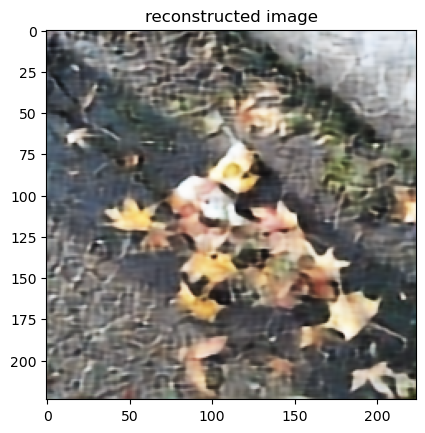

In [121]:
plt.imshow(original_output[0])
plt.title("reconstructed image")

In [200]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_images = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='filename',
    y_col='category',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)
valid_images=valid_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col='filename',
    y_col='category',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

Found 2275 validated image filenames belonging to 7 classes.
Found 258 validated image filenames belonging to 7 classes.


/opt/conda/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2342 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 256 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [201]:
for i in encoder.layers:
    i.freeze=True

In [202]:
import tensorflow_hub as hub
def get_from_hub(model_url):
    inputs = tf.keras.Input((224, 224, 3))
    hub_module = hub.KerasLayer(model_url,trainable=False)
    outputs = hub_module(inputs)
    return tf.keras.Model(inputs, outputs)

In [127]:
def se_block(inputs):
    input_channels = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(units=len(train_images.class_indices.keys()), activation="relu")(x)    
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)    
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x

In [128]:
swin=get_from_hub('https://tfhub.dev/sayakpaul/swin_large_patch4_window7_224_in22k_fe/1')

In [203]:
from tensorflow.keras import regularizers
x=swin.output
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(32, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x_swin = Dense(128, activation='relu')(x)

In [130]:
def get_model(base_model):
    x = tf.keras.layers.GlobalAveragePooling2D()(se_block(base_model.output))
    x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dense(256,activation='relu')(x)
    return Dense(128,activation='relu')(x)

In [204]:
x_encoder=get_model(encoder)


In [205]:
from tensorflow.keras.layers import concatenate
concatenated=concatenate([x_encoder,x_swin])
bigmodel_prediction = Dense(len(train_images.class_indices), activation='softmax')(concatenated)
model = Model([encoder.input,swin.input], bigmodel_prediction)
from tensorflow.keras.utils import plot_model
#plot_model(model)

In [206]:
trainable_params = sum([v.numpy().size for v in model.trainable_variables])
non_trainable_params = sum([v.numpy().size for v in model.non_trainable_variables])
print("trainable parametres: "+ str(trainable_params) + " non trainable parametres: "+ str(non_trainable_params))

trainable parametres: 519554 non trainable parametres: 194998612


In [142]:
def generator_two_img(gen):
    while True:
        X1i = gen.next()
        yield [X1i[0],X1i[0]], X1i[1]

In [207]:
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.legacy.Adam(),metrics=['accuracy'])

In [212]:
history = model.fit(
    generator_two_img(train_images),
    validation_data=generator_two_img(valid_images), 
    validation_steps=valid_images.n//batch_size,
    validation_batch_size=batch_size,
    steps_per_epoch=train_generator.n//batch_size,
    batch_size=batch_size,
    epochs=epoch,
)

Epoch 1/50
142/142 [==============================] - 79s 558ms/step - loss: 0.9571 - accuracy: 0.7632 - val_loss: 1.5223 - val_accuracy: 0.6198
Epoch 2/50
142/142 [==============================] - 80s 561ms/step - loss: 0.9486 - accuracy: 0.7641 - val_loss: 1.5673 - val_accuracy: 0.6198
Epoch 3/50
142/142 [==============================] - 80s 561ms/step - loss: 0.9412 - accuracy: 0.7667 - val_loss: 1.3762 - val_accuracy: 0.6529
Epoch 4/50
142/142 [==============================] - 80s 563ms/step - loss: 0.9443 - accuracy: 0.7632 - val_loss: 1.6423 - val_accuracy: 0.5744
Epoch 5/50
142/142 [==============================] - 80s 562ms/step - loss: 0.9443 - accuracy: 0.7614 - val_loss: 1.4867 - val_accuracy: 0.6364
Epoch 6/50
142/142 [==============================] - 80s 563ms/step - loss: 0.9344 - accuracy: 0.7711 - val_loss: 1.6704 - val_accuracy: 0.5785
Epoch 7/50
142/142 [==============================] - 80s 562ms/step - loss: 0.9344 - accuracy: 0.7760 - val_loss: 1.6020 - val_ac

In [213]:
model.save('model.h5')

/opt/conda/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/tmp/ipykernel_212/908720665.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax[0].plot(epochs , train_acc , 'go-' ,color='r', label = 'Training Accuracy')
/tmp/ipykernel_212/908720665.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.
  ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')


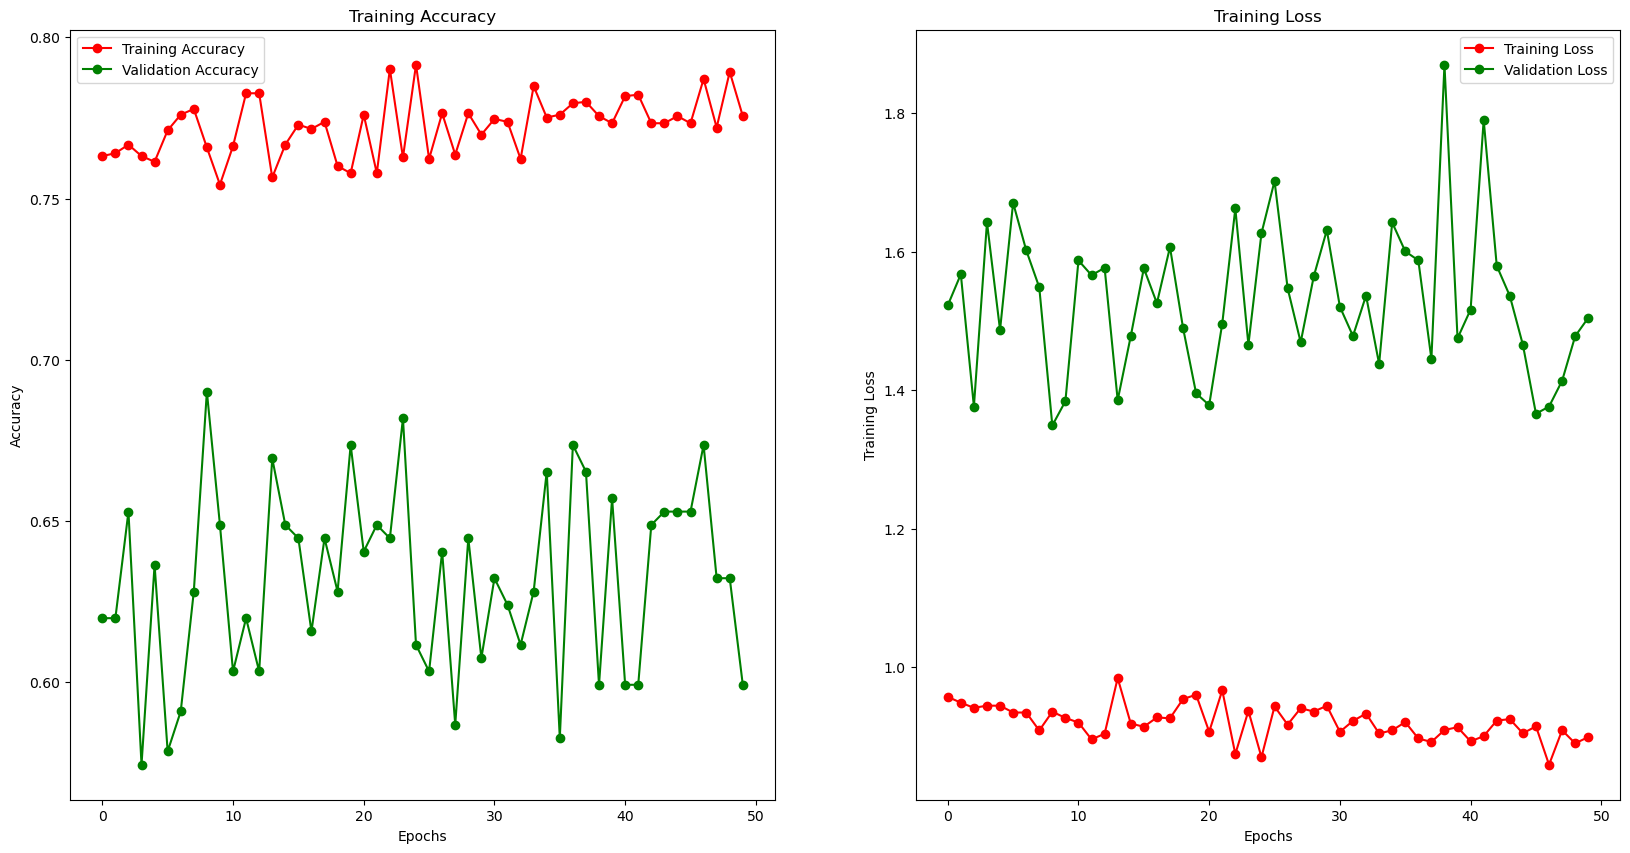

In [216]:
epochs = list(range(len(history.history['accuracy'])))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' ,color='r', label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'go-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

In [217]:
class_=train_images.class_indices.keys()


In [218]:
test_generator = ImageDataGenerator(
    rescale=1.0 / 255,
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='filename',
    y_col='category',
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset='training'
)

Found 639 validated image filenames belonging to 7 classes.


/opt/conda/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 641 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [219]:
def prediction_generator(test_images):
    k=0
    for x in test_images:
        k+=len(x[1])
        yield [x[0],x[0]], x[1]
        if(k>=test_images.n):
            break

In [220]:
from sklearn.metrics import accuracy_score
proba=model.predict(prediction_generator(test_images))
predicted = np.argmax(proba,axis=1)
true=test_images.labels
accuracy_score(predicted, true)

40/40 [==============================] - 22s 462ms/step


0.621283255086072

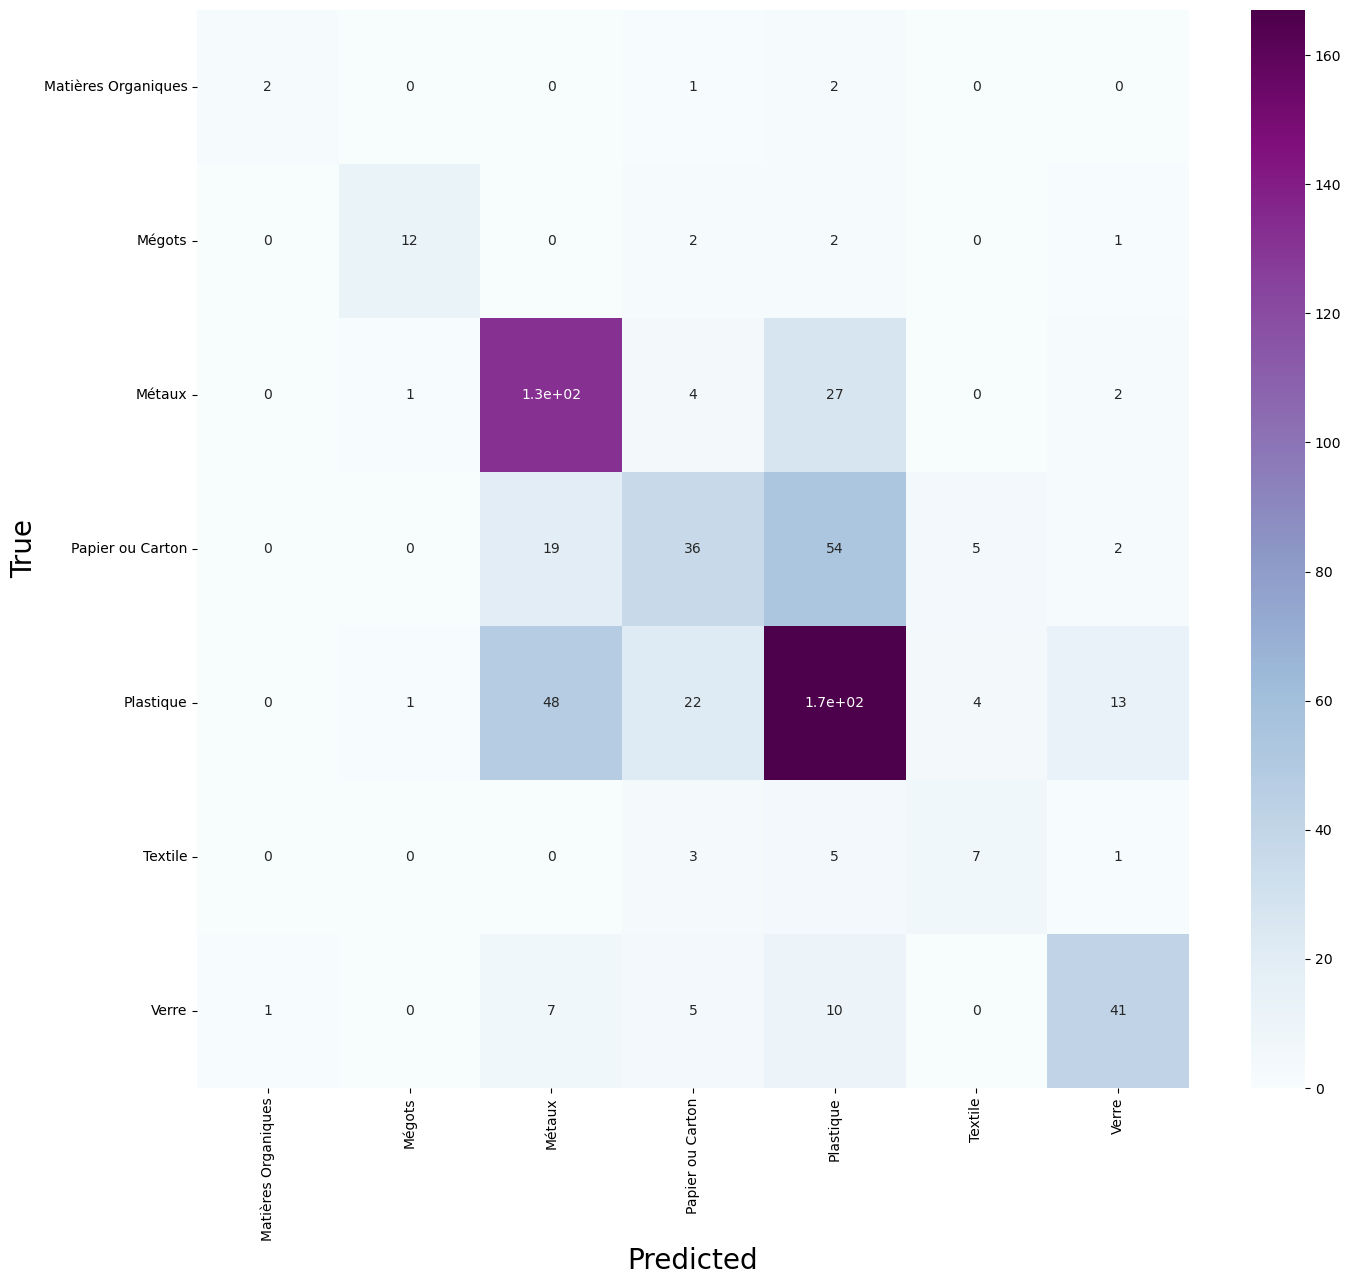

In [221]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_=test_images.class_indices.keys()
cm = confusion_matrix(true, predicted)
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="BuPu"); 
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_, fontsize = 10)
plt.yticks(rotation=0)

plt.title('', fontsize=60)

plt.savefig('ConMat24.png')
plt.show()

In [1]:
# I want to show the model's predictions on the test set

import random
import cv2

def show_predictions(test_images,proba):
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(test_images[i][0][0])
        ax.set_title(f"True: {test_images[i][1]} \n Predicted: {class_[np.argmax(proba[i])]}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [2]:
show_predictions(test_images,proba)

NameError: name 'test_images' is not defined

In [7]:
weight_path = '../../model.h5'

import tensorflow as tf

model = tf.keras.models.load_model(weight_path)


ValueError: Unknown layer: 'KerasLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.